# Mask detection with a Convolutional Neural Network (CNN)

### Gerard Martínez Espelleta


## Photo preprocessing

In [24]:
import pandas as pd
import os
import shutil
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

#### We define the photo paths

In [25]:
filenamesM = os.listdir("FaceMaskDataset\Train\WithMask")
filenamesNM = os.listdir("FaceMaskDataset\Train\WithoutMask")
srcdirM = "C:/Users/ger-m/Desktop/provaAPC/FaceMaskDataset/Train/WithMask/"
srcdirNM = "C:/Users/ger-m/Desktop/provaAPC/FaceMaskDataset/Train/WithoutMask/"
movdir = "C:/Users/ger-m/Desktop/provaAPC/FaceMaskDataset/Train/All/"

#### We move each photo to the same directory and change their names to make them easier to identify

In [26]:
for i, file in enumerate(filenamesM):
    shutil.copyfile(srcdirM + file, movdir + "/Mask_" + str(i) + ".png")
    
for i, file in enumerate(filenamesNM):
    shutil.copyfile(srcdirNM + file, movdir + "/NoMask_" + str(i) + ".png")

In [27]:
filenames = os.listdir("FaceMaskDataset\Train\All")

#### We create the database with the photo name and its label (1 if there is a mask or 0 if there is not)

In [28]:
noms = []
categories = []

for file in filenames:
    if file.split('_')[0] == 'Mask':
        categories.append(1)
    else:
        categories.append(0)

In [29]:
df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [30]:
from sklearn.utils import shuffle
df = shuffle(df)
df.reset_index(inplace=True, drop=True)

In [31]:
df.head()

,filename,category
0,NoMask_1256.png,0
1,Mask_2472.png,1
2,Mask_4955.png,1
3,NoMask_2940.png,0
4,NoMask_1613.png,0


#### We separate our data in a train and a test group

In [32]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.25, random_state=42)

#### We reshape our photos to be 32x32 px

In [33]:
import numpy as np
import matplotlib.image as mpimg
import cv2

train_images = []
train_labels = df_train['category']
for el in df_train['filename']:
    aux = mpimg.imread('FaceMaskDataset/Train/All' + '/' + el)
    aux = cv2.resize(aux, (32, 32), interpolation = cv2.INTER_AREA)
    train_images.append(aux)
    
test_images = []
test_labels = df_test['category']
for el in df_test['filename']:
    aux = mpimg.imread('FaceMaskDataset/Train/All' + '/' + el)
    aux = cv2.resize(aux, (32, 32), interpolation = cv2.INTER_AREA)
    test_images.append(aux)

In [34]:
x_t = np.array(train_images)
x_v = np.array(test_images)

## Model training

#### We import tensorflow and make sure that we have an available GPU

In [35]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


#### We define our model as a sequential model that have an input image of 32x32.

#### We also declare three filters of 3x3 each one

In [36]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

In [37]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

#### Here we can see how our model

In [38]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)               

#### We compile and fit it

In [39]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [40]:
history = model.fit(x_t, train_labels, epochs=10, 
                    validation_data=(x_v, test_labels))

Epoch 1/10
235/235 [==============================] - 2s 10ms/step - loss: 0.2727 - accuracy: 0.8887 - val_loss: 0.1035 - val_accuracy: 0.9648
Epoch 2/10
235/235 [==============================] - 2s 10ms/step - loss: 0.0757 - accuracy: 0.9729 - val_loss: 0.0495 - val_accuracy: 0.9836
Epoch 3/10
235/235 [==============================] - 2s 9ms/step - loss: 0.0474 - accuracy: 0.9827 - val_loss: 0.0429 - val_accuracy: 0.9864
Epoch 4/10
235/235 [==============================] - 2s 9ms/step - loss: 0.0397 - accuracy: 0.9861 - val_loss: 0.0471 - val_accuracy: 0.9836
Epoch 5/10
235/235 [==============================] - 2s 10ms/step - loss: 0.0342 - accuracy: 0.9881 - val_loss: 0.0380 - val_accuracy: 0.9892
Epoch 6/10
235/235 [==============================] - 2s 10ms/step - loss: 0.0291 - accuracy: 0.9899 - val_loss: 0.0460 - val_accuracy: 0.9892
Epoch 7/10
235/235 [==============================] - 2s 9ms/step - loss: 0.0335 - accuracy: 0.9881 - val_loss: 0.0460 - val_accuracy: 0.9840
Ep

#### Now we can check the accuracy of our model

79/79 - 0s - loss: 0.0332 - accuracy: 0.9900


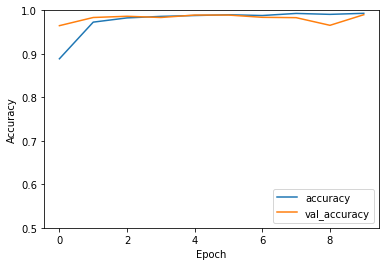

In [41]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(x_v,  test_labels, verbose=2)

#### As we can see, we have a very high accuracy.

## Working example

#### We firstly import some pictures of me and my friends

In [42]:
names = ["lola.png", "lola2.png", "ortega.jpg", "samuel.jpg", "sebas.jpg", "jo.jpeg"]

In [43]:
test = []
for el in names:
    aux = mpimg.imread('FaceMaskDataset/' + el)
    aux = cv2.resize(aux, (32, 32), interpolation = cv2.INTER_AREA)
    test.append(aux)

#### We then make a prediction about if we are or we are not wearing a mask

In [44]:
y_prob = model.predict(np.array(test)) 
y_classes = y_prob.argmax(axis=-1)

In [45]:
answ = []
for el in y_classes:
    if el == 0:
        answ.append("without mask")
    else:
        answ.append("with mask")
answ = np.array(answ)

#### We finally plot the results

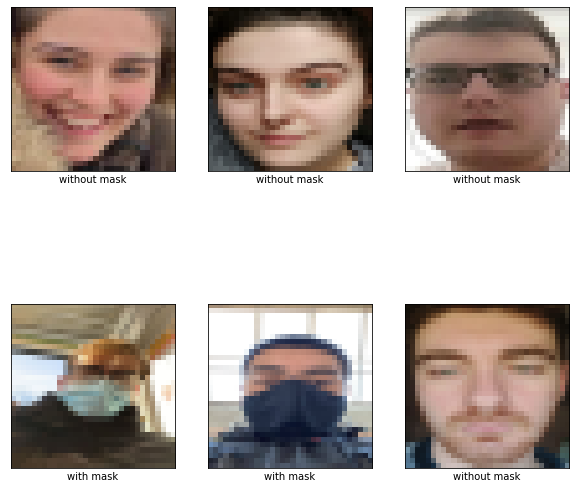

In [46]:
plt.figure(figsize=(10,10))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test[i], cmap=plt.cm.binary)
    plt.xlabel(answ[i])
plt.show()